In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install crepes

In [ ]:
import numpy as np
import pandas as pd

### Base de dados contruída utilizando a ferramenta MATPOWER do MATLAB. Cada linha da base corresponde a alguns estados do sistema para uma dada condição e a correspondente margem P de carga calculada por meio do **fluxo de potência continuado** com um incremento de carga $(\lambda)$ e utilizando as equações do fluxo de potência:

## $ P_{Gi}(\lambda)- P_{Li}(\lambda)-|V_m|_i \sum_{j=1}^n |V_m|_j|Y|_{ij} \cos(\delta_i -\delta_j-\theta_{ij})=0$

## $ Q_{Gi}(\lambda)- Q_{Li}(\lambda)-|V_m|_i \sum_{j=1}^n |V_m|_j|Y|_{ij} \sin(\delta_i -\delta_j-\theta_{ij})=0$

Onde cada termo é controlado por:



## *   ${P_{Li}(\lambda)}={P_{L0i}}(1+\lambda)$
## *   ${Q_{Li}(\lambda)}={Q_{L0i}}(1+\lambda)$
## *   ${ P_{Gi}(\lambda)}={P_{G0i}}(1+\lambda)$

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df = pd.read_csv('/content/drive/MyDrive/AlgoritmosDOC/Barras_Margem_Estabilidade/Bus4Contingecy.csv', sep = ',')

Geração dos ruídos a serem inseridos no código:
  
## $w=(\bar{X}+\Delta_{\rho,x}+\xi_\rho)e^{\bar{\phi}+\Delta_{\phi,x}+\xi_\phi}$

Onde:


## *   $\bar{X},\bar{\phi} $ são os valores absolutos das grandezas de magnitude e fase;
## *   $\Delta_{\rho,x} \sim \mathcal{N}(0,\sigma_\rho^2)$;

## *   $\Delta_{\phi,x} \sim \mathcal{N}(0,\sigma_\phi^2)$. 

Correção de valores máximos $(\alpha,\beta)$ para desvio-padrão correspondente a 99,73%:



## *   $\Delta_{\rho,x} \sim \mathcal{N}\left(0,\dfrac{\sigma \bar{X}}{3} \right)$
## *   $\Delta_{\phi,x} \sim \mathcal{N}\left(0,\dfrac{\theta_{max}}{3} \right)$

Para os erros sistemáticos:

## *   $\xi_\rho \sim U \left(-\Delta,+\Delta \right)$

Onde $\Delta$ é o valor absoluto do desvio máximo. No módulo, $\Delta=5\%$ e na fase $\Delta=9 \times 10^{-3} \ rad$.

In [ ]:
######## Theta máxima é dado em graus

thetamax =0.05729578

##############################################

########### Sigma é dado em porcentagem ######

sigma=0.001

##############################################

n=len(df['V2'])
np.random.seed(42)
wV2 = df['V2'] +(np.random.uniform(-df['V2'].mean() * (0.005), df['V2'].mean() * (0.005), n))+ (df['V2'].mean() * (sigma / 3)) * np.random.normal(0, 1, n)
np.random.seed(41)
wTheta2 = df['Theta2']+ (np.random.uniform(-0.34377468, 0.34377468, n)) +(thetamax / 3) * np.random.normal(0, 1, n)
np.random.seed(40)
wV6 = df['V6'] +(np.random.uniform(-df['V6'].mean() * (0.005),df['V6'].mean() * (0.005), n))+( df['V6'].mean() * (sigma / 3)) * np.random.normal(0, 1, n)
np.random.seed(39)
wTheta6 = df['Theta6']+(np.random.uniform(-0.34377468 , 0.34377468 , n)) + (thetamax / 3) * np.random.normal(0, 1, n)
np.random.seed(38)
wV9 = df['V9']+ (np.random.uniform(-df['V9'].mean() * (0.005), df['V9'].mean() * (0.005), n))+(df['V9'].mean() * (sigma / 3)) * np.random.normal(0, 1, n)
np.random.seed(37)
wTheta9 = df['Theta9']+ (np.random.uniform(-0.34377468, 0.34377468, n))+(thetamax / 3) * np.random.normal(0, 1, n)

In [ ]:
df['V2']=wV2
df['Theta2']=wTheta2
df['V6']=wV6
df['Theta6']=wTheta6
df['V9']=wV9
df['Theta9']=wTheta9

# Inserção de flags para:

# *   `N1 = 1` Quando há um elemento fora da rede;
# *   `N2 = 1` Quando há dois elementos fora da rede.



In [ ]:
n=3000 ### Numero de casos sem contingencia

n1=5000 #### Numero de casos com contingencia do tipo N-1

n2=2000 #### Numero de casos com contingencia do tipo N-2

N1=np.array([0 for x in range(n)]+[1 for x in range(n1)]+[0 for x in range(n2)])

N2=np.array([0 for x in range(n)]+[0 for x in range(n1)]+[1 for x in range(n2)])

In [ ]:
df.insert(24,'N1',N1)
df.insert(25,'N2',N2)
target = 'LoadMargin'
df=df.query('LoadMargin > 0')

In [ ]:
df

,V2,V6,V9,Theta2,Theta6,Theta9,P1,P4,Q4,P5,...,Q11,P12,Q12,P13,Q13,P14,N1,N2,Q14,LoadMargin
0,1.043226,1.069330,1.042236,-4.388380,-14.563669,-15.505482,219.16,50.680,-2.3934,9.0549,...,1.21520,5.8941,2.0124,7.1195,7.8151,16.184,0,0,6.3712,100.670
1,1.049188,1.065094,1.045148,-5.263093,-17.396800,-20.016941,257.81,61.553,-2.8238,8.8499,...,1.93170,7.7663,1.9200,12.5600,7.0251,16.872,0,0,5.7368,174.040
2,1.047483,1.072394,1.041043,-3.945208,-15.432852,-17.002717,213.30,22.686,-4.3438,8.0541,...,1.62290,8.7877,1.3553,20.4420,7.2234,11.442,0,0,5.6327,93.595
3,1.045603,1.067137,1.041575,-5.008248,-17.167525,-18.901714,243.85,49.735,-5.5813,8.9699,...,1.78750,4.3547,1.7065,16.9940,10.1860,13.882,0,0,4.3296,238.640
4,1.041890,1.069287,1.056813,-4.557956,-15.042710,-16.665111,223.79,47.440,-3.8937,8.2392,...,1.60290,5.8423,2.1690,11.2400,6.5473,13.914,0,0,6.7714,126.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.003615,1.004650,1.004507,1.077341,0.915866,1.246958,265.62,46.186,-4.0987,9.0884,...,1.11210,6.5710,0.9973,13.0280,5.8044,15.541,0,1,5.0348,125.500
9996,1.004296,1.000706,1.001257,1.166679,0.875536,0.701805,142.79,57.020,-4.2078,9.6114,...,1.25890,6.1885,1.2065,16.7000,2.3033,15.921,0,1,5.3283,165.140
9997,1.004863,0.995892,0.996577,0.788843,0.881969,1.249496,205.87,35.490,-4.2144,8.9285,...,2.20560,7.1938,1.2859,15.5980,9.9823,16.225,0,1,4.2395,100.540
9998,0.998725,1.000666,0.999416,1.289012,1.225160,1.219026,339.72,59.570,-3.4187,8.0719,...,0.79261,6.6131,2.4517,11.7950,4.9277,13.763,0,1,4.7200,158.750


In [ ]:
from google.colab import data_table
data_table.DataTable(df, include_index=False, num_rows_per_page=20)

$RMSE=\sqrt{\dfrac{1}{n} \displaystyle {\sum_{j=1}^n (y_j-\hat y_j)}}$

$MAE={\dfrac{1}{n} \displaystyle {\sum_{j=1}^n |y_j-\hat y_j|}}$

$MAPE={\dfrac{1}{n} \displaystyle {\sum_{j=1}^n  \dfrac{|y_j-\hat y_j|}{|y_j|} } }, \ \text{se} \ y_j \neq 0$

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    aux=[]
    for i in range(len(y_true)):
      if np.array(y_true)[i] !=0:
        desv=(abs((np.array(y_true)[i]-np.array(y_hat)[i])/np.array(y_true)[i]))
        aux.append(desv)
      else:
        aux.append(0)
    MAPE=abs(100*np.mean(aux))
    print('{} set RMSE:{}, R2:{}, MAPE:{}'.format(label, rmse, variance,MAPE))

In [ ]:
def evaluate2(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    aux=[]
    for i in range(len(y_true)):
      if np.array(y_true)[i] !=0:
        desv=(abs((np.array(y_true)[i]-np.array(y_hat)[i])/np.array(y_true)[i]))
        aux.append(desv)
      else:
        aux.append(0)
    MAPE=abs(100*np.mean(aux))
    return MAPE

# Polynomial Features grau (n)

## Criação de variáveis do tipo:

# $x_1, \ x_2, \ x_1x_2, \ x_1^2, \ x_2^2, \  x_1^2x_2^2, \ldots$

## Como forma de melhorar a performance da regressão.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

Y1=df['LoadMargin']

X1=df.drop(columns=['LoadMargin'])

trans = PolynomialFeatures(degree=2)

X1 = trans.fit_transform(X1)

# Implementação do melhor modelo obtido por meio do AutoML pycaret

## Nesse caso, Extra Tree Regressor:

[Link Para o Extra Tree Regressor em Python ](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

[Link para o paper original Extra Tree Regressor ](https://link.springer.com/content/pdf/10.1007/s10994-006-6226-1.pdf)

In [ ]:
Y1=df['LoadMargin']

X1=df.drop(columns=['LoadMargin'])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.3, random_state=42, shuffle=True)

reg1 = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train1, y_train1)

y_predict_train=reg1.predict(X_train1)
y_predict_test=reg1.predict(X_test1)

evaluate(y_train1,y_predict_train,'train')
evaluate(y_test1,y_predict_test)

train set RMSE:2.0728333412048306e-13, R2:1.0, MAPE:1.2270042012696576e-13
test set RMSE:14.636318040527375, R2:0.8474950723554325, MAPE:6.649322056159324


In [ ]:
Y1=df['LoadMargin']

X1=np.array(df['P4']).reshape(-1, 1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.3, random_state=42, shuffle=True)

reg1 = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train1, y_train1)

y_predict_train=reg1.predict(X_train1)
y_predict_test=reg1.predict(X_test1)

evaluate(y_train1,y_predict_train,'train')
evaluate(y_test1,y_predict_test)

train set RMSE:10.090648171501586, R2:0.9290757147927834, MAPE:3.005272540866942
test set RMSE:28.347518304287476, R2:0.42792852994549546, MAPE:15.210636541794539


# Busca dos melhores hyperparâmetros do Modelo escolhido

## A busca é feita por exaustão. Rodando os modelos com cada combinação

In [ ]:
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
    estimator=reg1,
    param_grid={
       'n_estimators': range(50,126,25),
       'max_features': range(50,401,50),
       'min_samples_leaf': range(20,50,5),
       'min_samples_split': range(15,36,5),
       "max_depth" : [1,3,5,7,9,11,12],
    },
    scoring='neg_mean_absolute_percentage_error',
    cv=5
)

grid_result = gsc.fit(X_train1, y_train1)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.087786 using {'max_depth': 12}


In [ ]:
!pip install shap

# SHAP Values como método de Explainable AI


In [ ]:
#### Shap aplicado de forma direta ######

import shap as shap
explainer = shap.Explainer(reg1.predict, X_test1)
shap_values = explainer(X_test1)

Permutation explainer: 3000it [43:02,  1.16it/s]


In [ ]:
#### Tree-SHAP, possível apenas para modelos em árvore ######

import shap as shap

explainer = shap.TreeExplainer(reg1)

shap_values = explainer(X_test1)

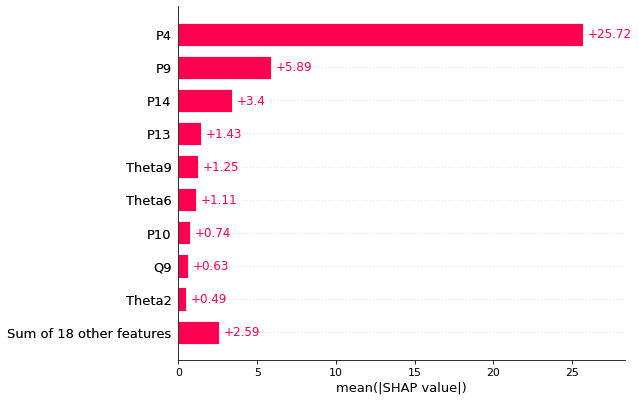

In [ ]:
shap.plots.bar(shap_values)

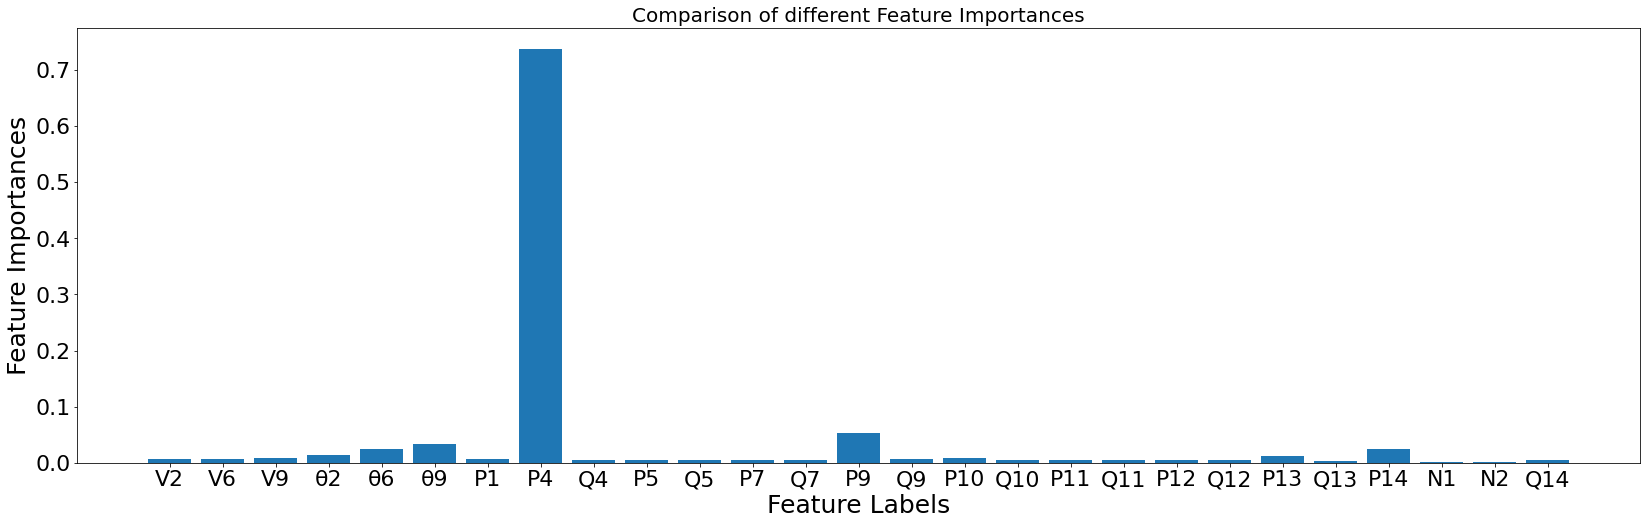

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (28,8))

axis_font = {'fontname':'Helvetica', 'size':'22'}

feature_importance = reg1.feature_importances_

O=list(X_train1.columns)

O[3]='\u03B82'

O[4]='\u03B86'

O[5]='\u03B89'

plt.bar(O, feature_importance)
plt.xlabel('Feature Labels',fontsize=25)
plt.ylabel('Feature Importances',fontsize=25)
plt.yticks(fontsize=20,**axis_font)
plt.xticks(fontsize=20,**axis_font)
plt.title('Comparison of different Feature Importances',fontsize=20)
plt.show()

In [ ]:
D={'Features':X_train1.columns,'Feature Importance':feature_importance}

df2 = pd.DataFrame(data=D)

df_aux=df2.sort_values(by=['Feature Importance'],ascending=False)

df_aux2=df_aux[df_aux['Feature Importance']<0.01]

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(reg1, random_state=42).fit(X_test1, y_test1)
eli5.show_weights(perm, feature_names = X_train1.columns.tolist())

Weight,Feature
1.5943 ± 0.0636,P4
0.0875 ± 0.0059,P9
0.0617 ± 0.0094,Theta9
0.0339 ± 0.0048,P14
0.0279 ± 0.0056,Theta6
0.0143 ± 0.0015,Theta2
0.0072 ± 0.0019,P13
0.0048 ± 0.0012,V6
0.0035 ± 0.0008,V9
0.0022 ± 0.0007,P1


# Feature Selection via Select from Model usando *Informação de Gini*

## **Threshold** inicial foi colocado como **18% do valor médio** dos coeficientes de importância

In [ ]:
th=np.array((reg1.feature_importances_)).mean()*0.18

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=50, random_state=42),threshold=th).fit(X_train1, y_train1)

X=selector.transform(X1)

saida=selector.get_feature_names_out()

In [ ]:
saida

array(['V2', 'V6', 'V9', 'Theta2', 'Theta6', 'Theta9', 'P1', 'P4', 'P9',
       'Q9', 'P10', 'P11', 'P13', 'P14'], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.3, random_state=42, shuffle=True)

reg = ExtraTreesRegressor(n_estimators=50, random_state=42).fit(X_train, y_train)

y_predict=reg.predict(X_test)

evaluate(y_test,y_predict)

test set RMSE:1.2277695458563553, R2:0.8663129661029705, MAPE:6.888265979463708


# **Otimização do Threshold para o feature selection**

In [ ]:
from sklearn.feature_selection import SelectFromModel

Npontos=50

percent=np.linspace(0.01,0.7,Npontos)

resultados=[]

for i in range(len(percent)):

  th=np.array((reg1.feature_importances_)).mean()*percent[i]

  selector = SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=50, random_state=42),threshold=th).fit(X_train1, y_train1)

  X=selector.transform(X1)

  X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.3, random_state=42, shuffle=True)

  reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

  y_predict=reg.predict(X_test)

  resultados.append(evaluate2(y_test,y_predict))

In [ ]:
resultados2=[j-0.6 for j in resultados]

min(resultados2)

5.830378221285748

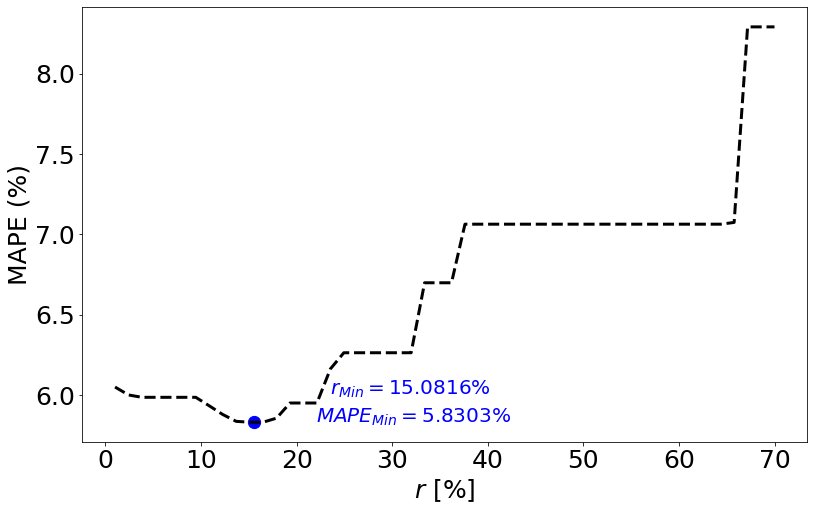

In [ ]:
resultados=np.array(resultados)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (13,8))

axis_font = {'fontname':'sans-serif', 'size':'25'}

plt.xlabel(r'$r \ [\%]$',**axis_font)
plt.ylabel('MAPE (%)',**axis_font)
plt.yticks(fontsize=25,**axis_font)
plt.xticks(fontsize=25,**axis_font)

plt.plot(100*percent,resultados2,'k--',linewidth=3.0)

plt.scatter(15.5,5.8303,s=150,color='b')

plt.text(23.5,6,r'$r_{Min}=15.0816\%$',color='b',fontsize=20)

plt.text(22,5.8303,r'$MAPE_{Min}=5.8303\%$',color='b',fontsize=20)

plt.savefig('/content/drive/MyDrive/AlgoritmosDOC/Barras_Margem_Estabilidade/FeatureSelection.eps', format='eps')

plt.show()

In [ ]:
menor=min(resultados2)

index=resultados2.index(menor)

print('O Threshold ótimo é %f %% resultando em um MAPE = %.6f %%' %(percent[index]*100, menor))

O Threshold ótimo é 15.081633 % resultando em um MAPE = 5.830378 %


In [ ]:
from sklearn.feature_selection import SelectFromModel

th_otimo=np.array((reg1.feature_importances_)).mean()*percent[index]

selector = SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=50, random_state=42),threshold=th_otimo).fit(X_train1, y_train1)

X=selector.transform(X1)

saida=selector.get_feature_names_out()

print(saida)

['V2' 'V6' 'V9' 'Theta2' 'Theta6' 'Theta9' 'P1' 'P4' 'P9' 'Q9' 'P10' 'P13'
 'P14']


## **Análise CONFORMAL PREDICTION**

## Conformal prediction using Standard conformal regressors

In [ ]:
from crepes import ConformalRegressor, ConformalPredictiveSystem
from crepes.fillings import (sigma_variance,sigma_variance_oob,sigma_knn,binning)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.5, random_state=42, shuffle=True)

X_proper_training, X_calibration, y_proper_training, y_calibration = train_test_split(X_train1, y_train1, test_size=0.25)

learner_proper = ExtraTreesRegressor(n_estimators=100, random_state=42)

learner_proper.fit(X_proper_training, y_proper_training)

ExtraTreesRegressor(random_state=42)

In [ ]:
cr_standard = ConformalRegressor()

residuals_calibration = y_calibration - learner_proper.predict(X_calibration)

cr_standard.fit(residuals=residuals_calibration)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [ ]:
y_hat_proper = learner_proper.predict(X_test1)

intervals = cr_standard.predict(y_hat=y_hat_proper, confidence=0.95)

display(intervals)

array([[10.83073 , 19.93903 ],
       [12.78789 , 21.89619 ],
       [12.15712 , 21.26542 ],
       ...,
       [17.751088, 26.859388],
       [20.40088 , 29.50918 ],
       [ 6.935781, 16.044081]])

In [ ]:
Delta=[]

for i in range(len(intervals)):
  Delta.append(intervals[i][1]-intervals[i][0])

In [ ]:
max(Delta)

9.10829999999999

## **Análise CONFORMAL PREDICTION**
## Conformal prediction using Normalized conformal regressors

In [ ]:
sigmas_calibration_var = sigma_variance(X=X_calibration,learner=learner_proper)

cr_normalized_var = ConformalRegressor().fit(residuals=residuals_calibration, sigmas=sigmas_calibration_var)

sigmas_test_var = sigma_variance(X=X_test1, learner=learner_proper)

intervals_normalized_var = cr_normalized_var.predict(y_hat=y_hat_proper, sigmas=sigmas_test_var)


In [ ]:
intervals_normalized_var

array([[14.45503039, 16.31472961],
       [15.80590785, 18.87817215],
       [15.56896424, 17.85357576],
       ...,
       [-0.63307251, 45.24354851],
       [20.7862243 , 29.1238357 ],
       [10.68247679, 12.29738521]])

## **Análise CONFORMAL PREDICTION**

## Conformal prediction using Standard regressors with out-of-bag calibration


In [ ]:
learner_full = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, random_state=42,bootstrap=True, oob_score=True)
learner_full.fit(X_train1, y_train1)
residuals_oob = y_train1 - learner_full.oob_prediction_

In [ ]:
cr_standard_oob = ConformalRegressor().fit(residuals=residuals_oob)

y_hat_full = learner_full.predict(X_test1)

intervals_standard_oob = cr_standard_oob.predict(y_hat=y_hat_full)

display(intervals_standard_oob)

array([[ 9.65212 , 20.65732 ],
       [11.70523 , 22.71043 ],
       [11.43953 , 22.44473 ],
       ...,
       [16.826176, 27.831376],
       [19.56668 , 30.57188 ],
       [ 5.646401, 16.651601]])